# Solving TSP using vcopt

The travelling salesman problem is perhaps one of the most commonly known path optimisation problems which shows up in one form or another in our daily life. Imagine this: it is the weekend and you have a list of errands scattered all over the city that you want to complete before the day is over. You want to get everything done in the most efficient way possible, whether that involves travelling the least total distance, using the least fuel, or spending the least amount on tolls etc. The question is given the list of destinations and a certain aim (and maybe a few restraints), what is the optimum way of scheduling our errands for the day?

There are many methods available to solve this: Brute Force, Dynamic Programming, and Greedy Methods are just a few. In this notebook, we will focus on how we can use the [vcopt library's](https://pypi.org/project/vcopt/) methods to implement the Genetic Algorithm method in just a few simple steps.

Docs: https://vigne-cla.com/vcopt-specification/#toc9

Reference: https://vigne-cla.com/9-1/


# Single-agent TSP

We begin by considering the case where there is only one salesman. We let the cost of travelling between cities be simply the distance between each city. We also set the constraint that the start and end points must be the same, and we can only pass through each city once.

## Import Libraries

In [445]:
# import libs

import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import random
import copy
import time

from vcopt import vcopt


## Initialise Parameters

We first initialise the following parameters:

1) NO_TOWNS: Number of towns to visit
2) STARTING_TOWN: Town number of the starting town (:NO_TOWNS)

We then define a function create_towns to randomly assign (x, y) coordinates to each of these towns.


In [5]:
# init parameters

NO_TOWNS = 20 # number of towns (town numbering is from [0, NO_TOWNS-1])
STARTING_TOWN = 0 # set starting town
nr.seed(69) # set fixed seed for rng


# Create TSP Problem

First, we will create a function to generate random coordinates for each town. Since our starting point and end points are going to be fixed, we will not need to consider the STARTING_TOWN in our permutations. However, we will need to consider the cost between the 2nd town and the STARTING_TOWN. We will also need to consider the cost between the 2nd last town, and the final town (which in this case is the STARTING_TOWN again).

We will remove the STARTING_TOWN from our path for now, so that the vcopt optimiser will not consider it as part of the permutations. We will bring the STARTING_TOWN's cost back in our cost function later on.

**NOTE: vcopt requires its paths/chromosones to be a list or np.array.**

In [228]:
# function for creating town coordinates
def create_towns(NO_TOWNS):
    """generate random x and y coordinates for each town"""

    towns_x = nr.rand(NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.rand(NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return towns_x, towns_y


towns_x, towns_y = create_towns(NO_TOWNS) # generate coordinates for each town

path = np.arange(NO_TOWNS) # generate a random initial path that passes through all towns 
path = np.delete(path, np.where(path==STARTING_TOWN)) # remove the starting town from the path


# Define Cost Function for optimisation

We now define a cost function in order to score each path. Here, our cost is split into three parts:

1) Costs between each non-start and non-finish town.
2) Costs between start town and 2nd town
3) Costs between 2nd last town and end town.

For our case, the costs is just the distance between each town.

In [232]:
# create scoring function for current path

def score_func(path):
    
    current_towns_x = towns_x[path][:-1]
    current_towns_y = towns_y[path][:-1]
    next_towns_x = towns_x[path][1:]
    next_towns_y = towns_y[path][1:]
    
    start_town_x = towns_x[path][STARTING_TOWN]
    start_town_y = towns_y[path][STARTING_TOWN]
    
    # add costs between each non-starting town according to path
    cost = sum(((towns_y[path][1:] - towns_y[path][:-1])**2 + (towns_x[path][1:] - towns_x[path][:-1])**2)**0.5)
    # add cost between first non-starting town and start town
    cost += ((towns_x[path][0] - start_town_x)**2 + (towns_y[path][0] - start_town_y)**2)**0.5 
    # add cost between last non-starting town and start town
    cost += ((towns_x[path][-1] - start_town_x)**2 + (towns_y[path][-1] - start_town_y)**2)**0.5
    
    return cost

# Create plotting function to visualise optimisation process

In [233]:
# def plotting function for visualising paths at every step of optimisation


def tsp_show_pool(pool, **info):
    """function for visualising path at each generation"""
    # access the info dictionary provided by tspGA() function to get metrics

    
    gen = info['gen']
    best_index = info['best_index']
    best_score = info['best_score']
    mean_score = info['mean_score']
    mean_gap = info['mean_gap']
    time = info['time']
    
    
    plt.figure(figsize=(6, 6))
    
    # visualise some of the paths in each generation's population
    for para in pool[:10]:
        plt.plot(towns_x[para], towns_y[para], 'ok-', alpha=0.1)
    
    best_path_of_pool = np.concatenate(([STARTING_TOWN], pool[best_index], [STARTING_TOWN]))
    print(best_path_of_pool)
    plt.plot(towns_x[best_path_of_pool], towns_y[best_path_of_pool], 'or-')
    plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
    plt.xlabel('x'); plt.ylabel('y')
    
    for i, xy in enumerate(zip(towns_x, towns_y), 0):
        plt.text(xy[0]+0.01, xy[1]+0.01, s=i)
        
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.title('gen={}, best={:.3f} mean={:.3f} time={:.3f}'.format(gen, best_score, mean_score, time))
    plt.show()


[ 5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15]
________________________________________ info ________________________________________
para_range     : n=19
score_func     : <class 'function'>
aim            : ==0.0
show_pool_func : '<function tsp_show_pool at 0x0000020C5A0B89D0>'
seed           : 69
pool_num       : 190
max_gen        : None
core_num       : 1 (*vcopt, vc-grendel)
_______________________________________ start ________________________________________
Scoring first gen 190/190        
Mini 2-opting first gen 190/190        
[ 0 14 11  5  9  3 10 15 12  7 17  6  4 13  1 16 19  8 18  2  0]


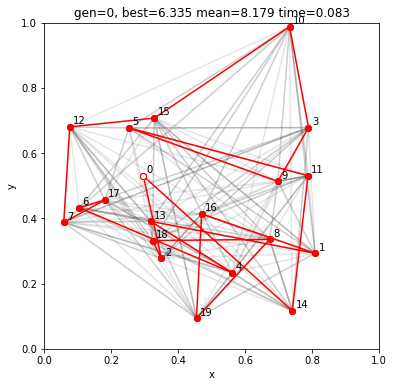

[ 0  6 12  7 17 10  3 19  2 18 16  4 13  8  1 11  9 14  5 15  0]


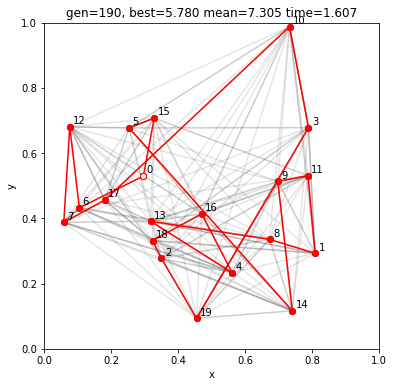

[ 0  6 12  7 17 13  4 16 18  2 19  3 10  8  1 11  9 14  5 15  0]


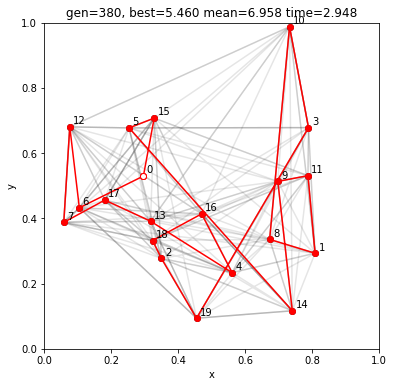

[ 0  6 12  7 17 13  4 16 18  2 19  3 10  8  1 11  9 14 15  5  0]


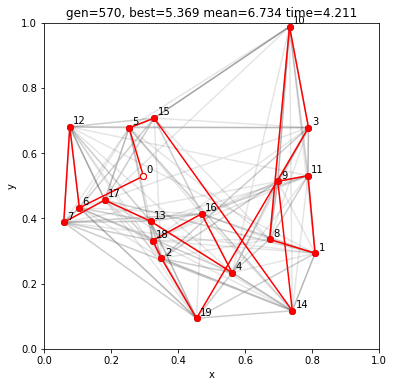

[ 0  6 12  7 17 13  4 19  2 18 16  3 10  8  1 11  9 14 15  5  0]


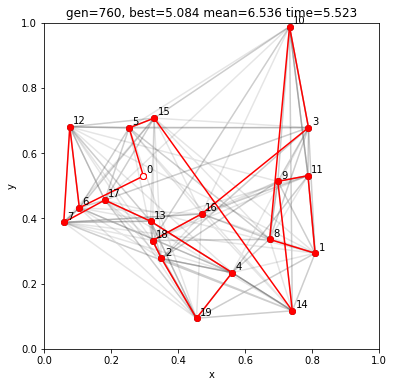

[ 0  6 12  7 17 13  4 19  2 18 16  3 10  8  1 14  9 11 15  5  0]


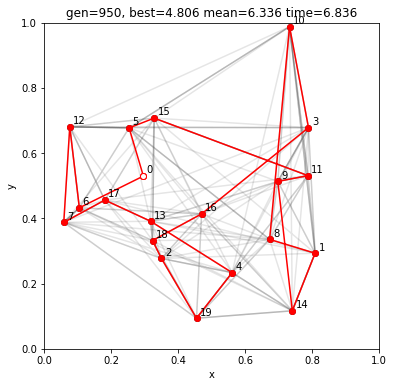

[ 0  6 12  5 15 11  9 14  1  8 10  3 16 18  2 19  4 13 17  7  0]


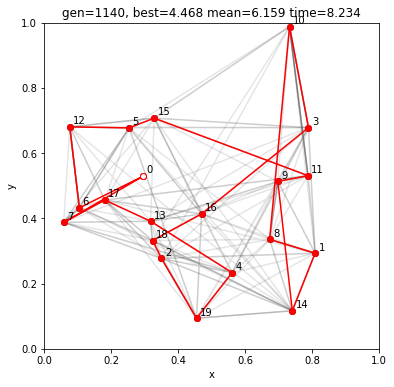

[ 0  6 12  5 15 11  9  1 14  8 10  3 16 18  2 19  4 13 17  7  0]


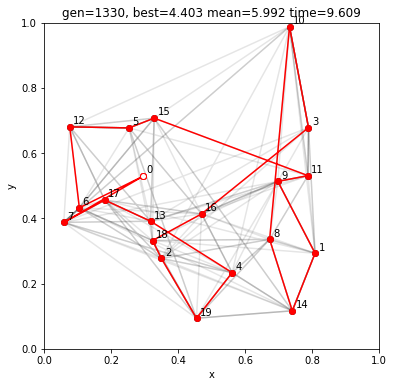

[ 0  6 12  5 15 11  3 10  8 14  1  9 16 18  2 19  4 13 17  7  0]


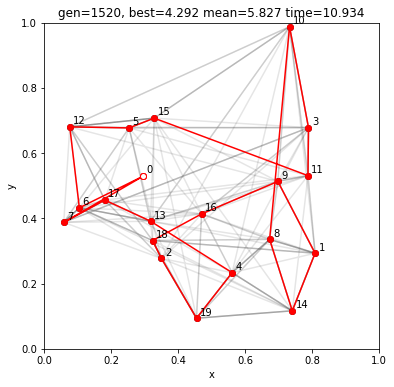

[ 0  6 12  5 15  1 14  8 10  3 11  9 16 18  2 19  4 13 17  7  0]


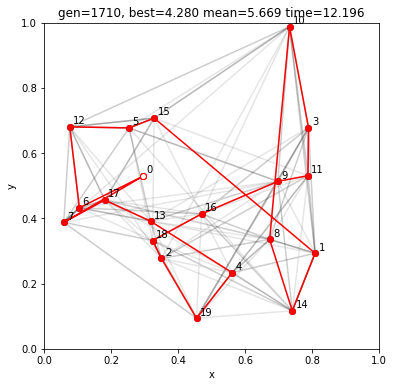

[ 0  6 12  5 15  3 10  8 14  1 11  9 16 18  2 19  4 13 17  7  0]


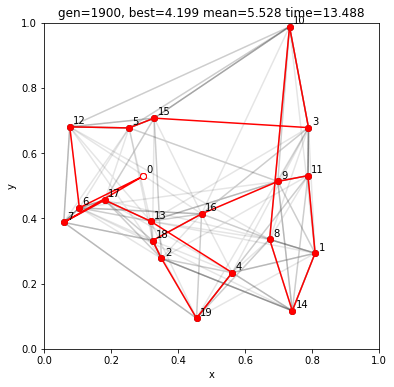

[ 0  5 12  6  7 13 17 18  2 19  4 14  1  8  9 11  3 10 16 15  0]


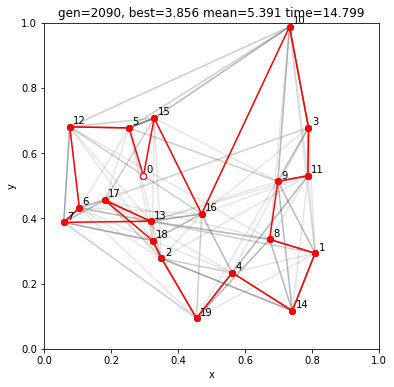

[ 0  5 12  6  7 13 16 10  3 11  9  8  1 14  4 19  2 18 17 15  0]


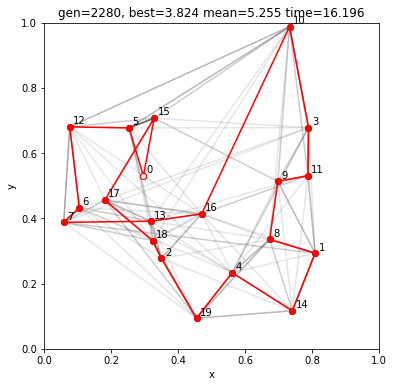

[ 0  5 12  6  7 13 16 17 18  2 19  4 14  1  8  9 11  3 10 15  0]


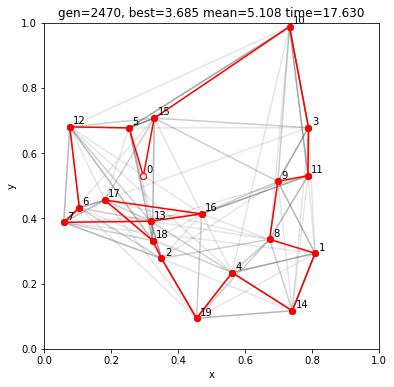

[ 0  5 12  6  7 17 16 13 18  2 19  4 14  1  8  9 11  3 10 15  0]


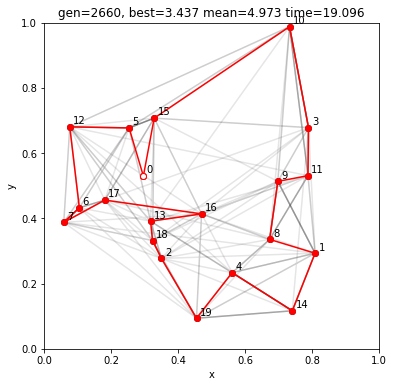

[ 0  5 12  7  6 17 16 13 18  2 19  4 14  1  8  9 11  3 10 15  0]


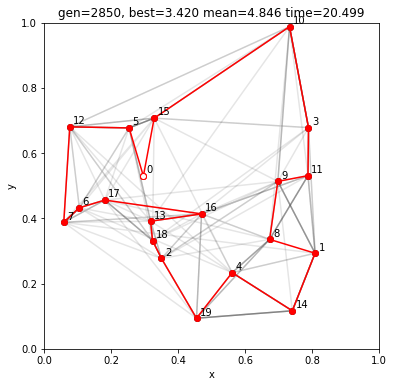

[ 0  5 12  7  6 17 13 16 18  2 19  4 14  1  8  9 11  3 10 15  0]


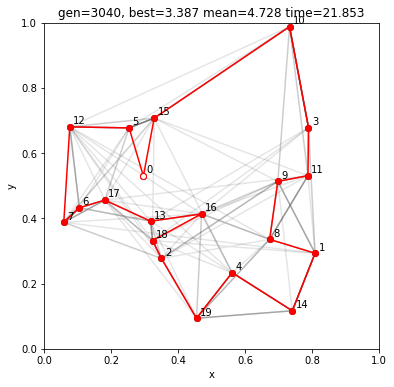

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


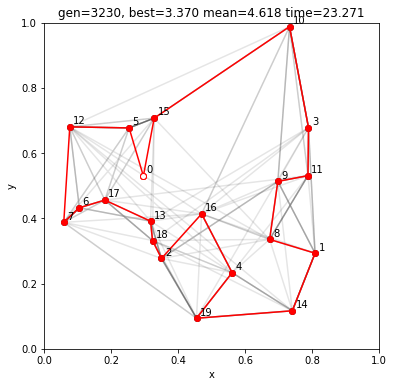

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


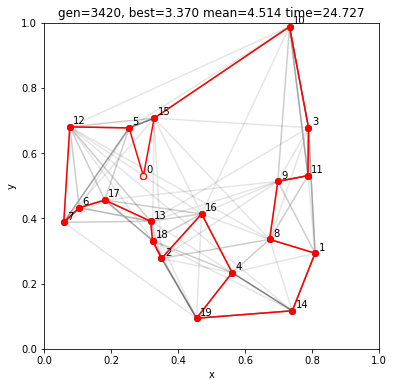

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


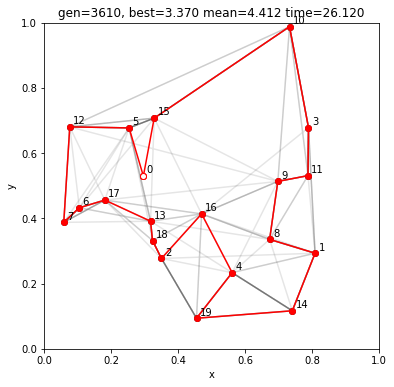

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


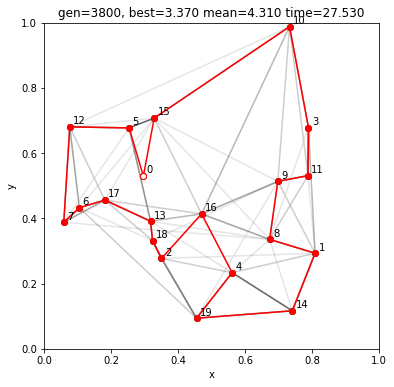

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


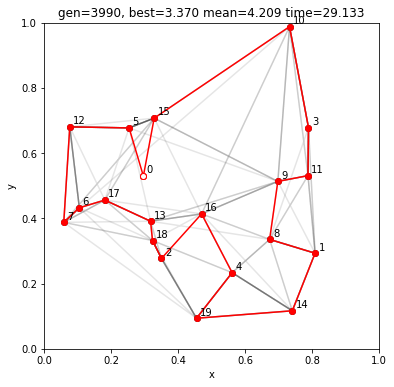

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


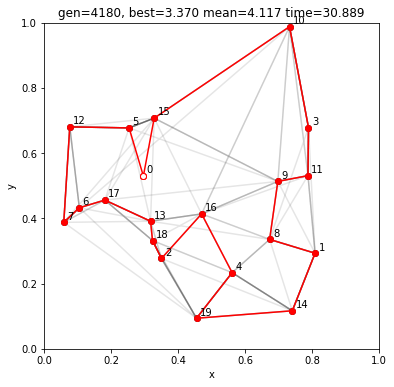

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


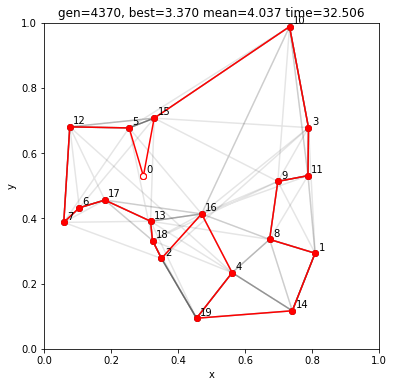

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


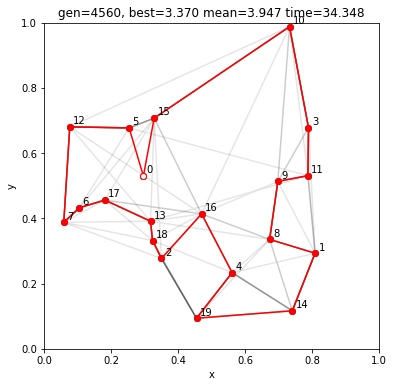

[ 0  9  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  0]


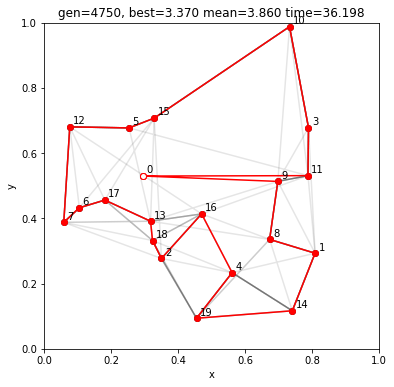

[ 0  9  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  0]


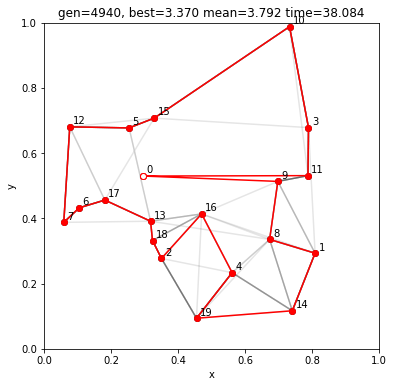

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


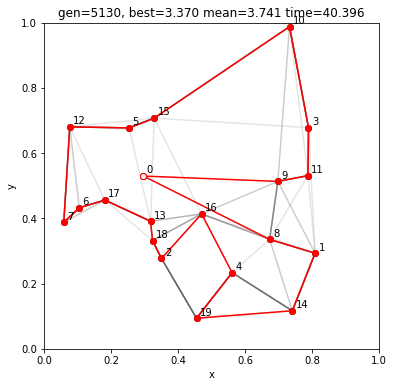

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


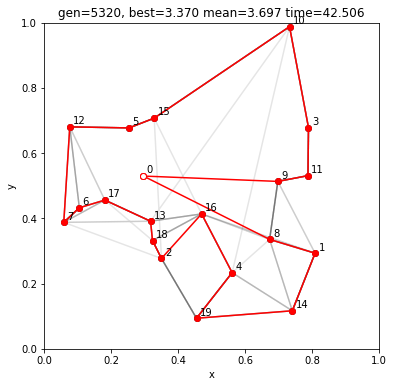

[ 0  9  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  0]


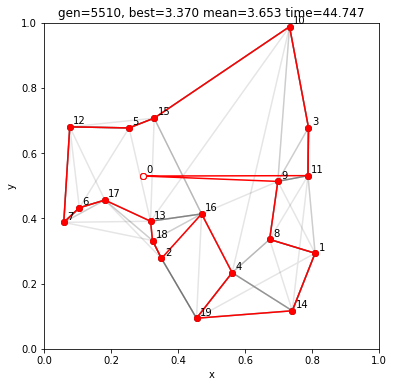

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


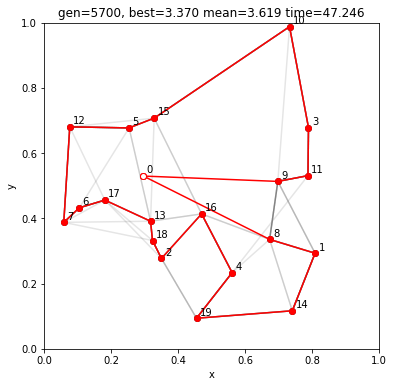

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


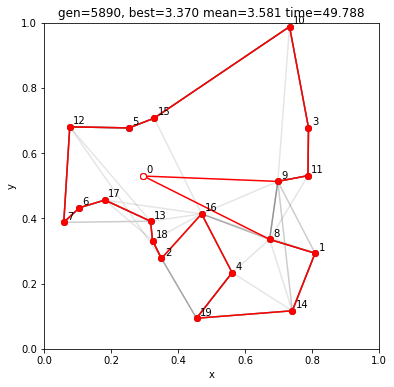

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


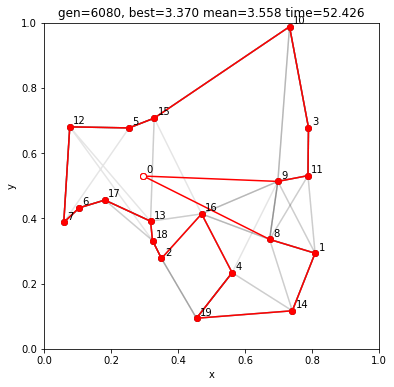

[ 0  9  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  0]


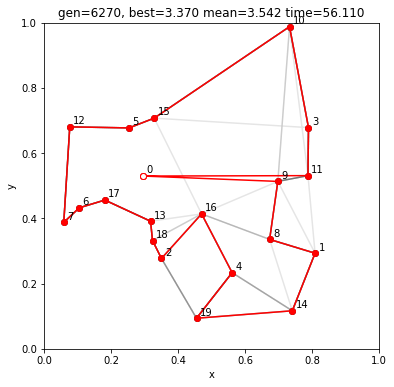

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


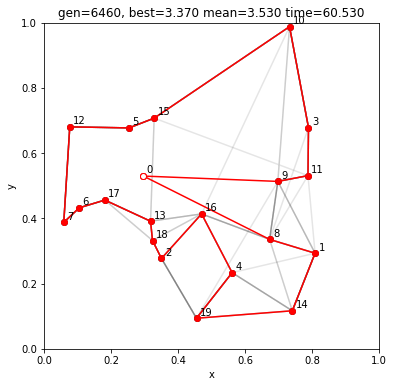

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


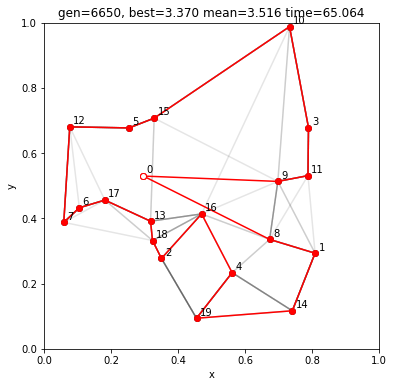

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


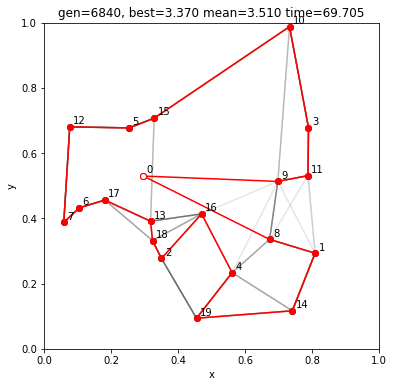

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


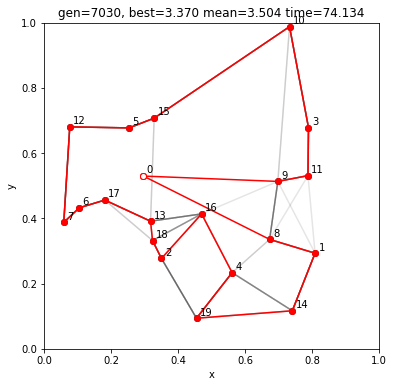

[ 0  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  5 12  0]


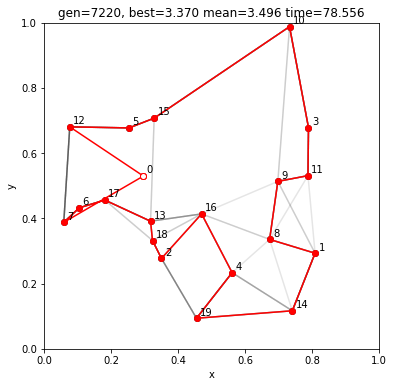

[ 0  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  9  0]


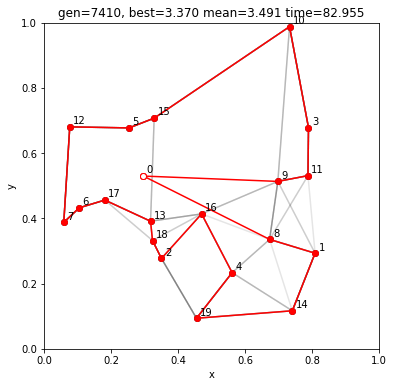

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


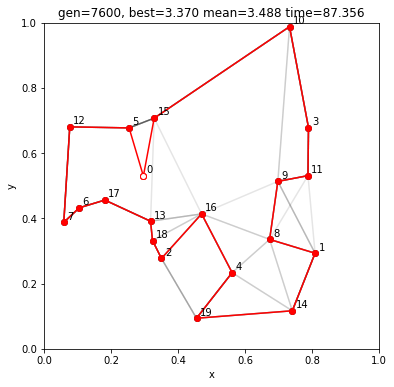

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


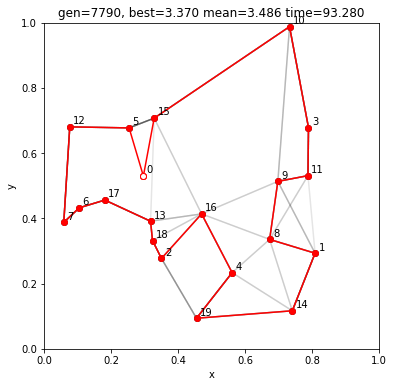

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


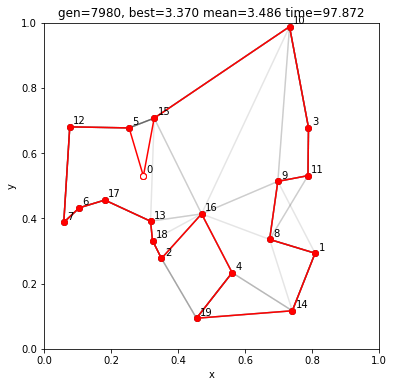

[ 0  9  8  1 14 19  4 16  2 18 13 17  6  7 12  5 15 10  3 11  0]


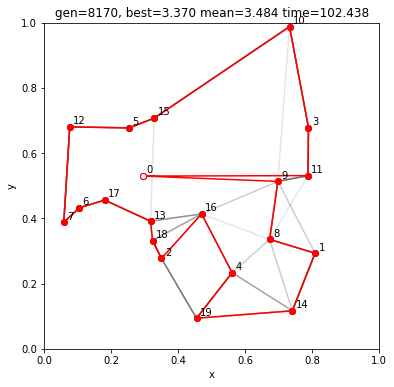

[ 0  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  5 12  0]


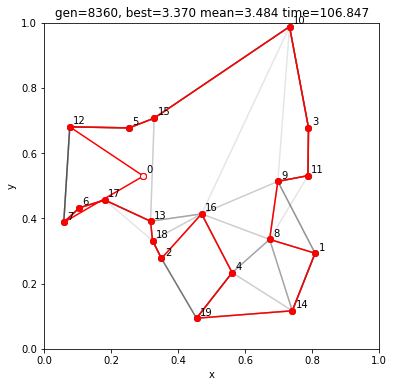

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


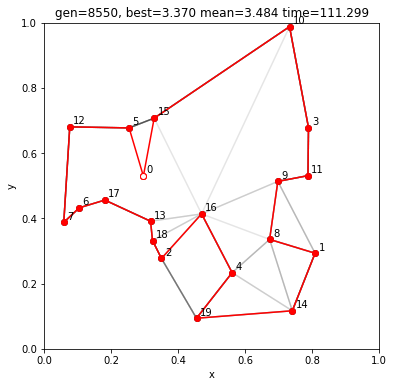

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


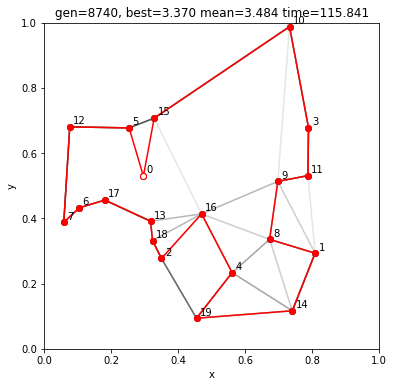

[ 0  5 12  7  6 17 13 18  2 16  4 19 14  1  8  9 11  3 10 15  0]


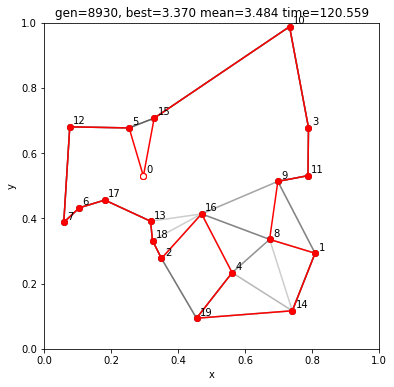

_______________________________________ result _______________________________________
para = np.array([5, 12, 7, 6, 17, 13, 18, 2, 16, 4, 19, 14, 1, 8, 9, 11, 3, 10, 15])
score = 3.3702589789908783
________________________________________ end _________________________________________
[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]
3.3702589789908783
CPU times: total: 1min 56s
Wall time: 2min


In [234]:
%%time

print(path)

path, score = vcopt().tspGA(path,
                            score_func,
                            0.0, # we want to minimise our score which measures total distance
                            show_pool_func=tsp_show_pool,
                            seed=69,
                            ) 

print(para)
print(score)

In [ ]:
plt.figure(figsize=(6, 6))

for i in range(NO_TOWNS):
    if i == STARTING_TOWN:
        plt.scatter(towns_x[i], towns_y[i], c='white', edgecolors='red')
        
    else:
        plt.scatter(towns_x[i], towns_y[i], c='red')
        

    plt.text(towns_x[i]+0.01, towns_y[i]+0.01, i)

plt.title(f'TSP Problem with {NO_TOWNS} towns', fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('Init.png', facecolor='white', transparent=False)



In [ ]:


plt.figure(figsize=(6, 6))

best_path = np.concatenate(([STARTING_TOWN], para, [STARTING_TOWN]))

plt.plot(towns_x[best_path], towns_y[best_path], 'or-')
plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X

for i, xy in enumerate(zip(towns_x, towns_y), 0):
    plt.text(xy[0]+0.01, xy[1]+0.01, s=i)

plt.title(f'Final Optimised Path\nCost={score:.3}, Runtime=1min', fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('40 Cities Optimised Path.png', facecolor='white', transparent=False)



In [ ]:
# import libraries

import os
import imageio



In [ ]:
png_dir = 'training_images'
images = []
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations/Init.png'))
    
for file_name in sorted([int(i.replace('.png','')) for i in os.listdir(png_dir)]):
    file_path = os.path.join(png_dir, str(file_name) + '.png')
    images.append(imageio.v2.imread(file_path))
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations/40 Cities Optimised Path.png'))
    
imageio.mimsave('training_gif.gif', images, duration=0.1)



# GA (Self Implementation)

Crossover Operators https://www.hindawi.com/journals/cin/2017/7430125/

In [2]:
import itertools

In [496]:
def create_towns(NO_TOWNS):
    """Generate random x and y coordinates for each town"""

    towns_x = nr.rand(NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.rand(NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return towns_x, towns_y


def score_func(path):
    """
    Scoring function for a given path
    Currently based on distance between towns in path        

    """
    
    current_towns_x = towns_x[path][:-1]
    current_towns_y = towns_y[path][:-1]
    next_towns_x = towns_x[path][1:]
    next_towns_y = towns_y[path][1:]
    
    start_town_x = towns_x[path][STARTING_TOWN]
    start_town_y = towns_y[path][STARTING_TOWN]
    
    # add costs between each non-starting town according to path
    cost = sum(((towns_y[path][1:] - towns_y[path][:-1])**2 + (towns_x[path][1:] - towns_x[path][:-1])**2)**0.5)
    # add cost between first non-starting town and start town
    cost += ((towns_x[path][0] - start_town_x)**2 + (towns_y[path][0] - start_town_y)**2)**0.5 
    # add cost between last non-starting town and start town
    cost += ((towns_x[path][-1] - start_town_x)**2 + (towns_y[path][-1] - start_town_y)**2)**0.5
    
    return cost


def create_population(path, NO_POOL):
    """
    Generate a population by finding NO_POOL permutations of an initial given path
    
    """
    
    population = []
    costs = []
    
    for i in range(NO_POOL):
        pool = np.array(random.sample(list(path), len(path)))
        population.append(pool)        
        costs.append(score_func(pool))
                     
    return population, costs


def choose_pool(population, costs):
    """
    Randomly choose a pool from a population.
    Pools with higher costs have lower probability of being chosen.
    """
    
        
    costs = np.array(costs)
    probs = np.exp(-costs)/sum(np.exp(-costs))
    cum_probs = np.cumsum(probs)
    
    choice = np.argwhere(nr.random()<=cum_probs)[0][0]

    return choice


def reproduce(population, costs):
    """
    First chooses 2 parent pool from current population via choose_pool.
    Then generates two child pool via CX2 crossover algorithm (Hussain et al., 2017).
    
    References:
    Hussain, A., Muhammad, Y. S., Nauman Sajid, M., Hussain, I., Mohamd Shoukry, A., &amp; Gani, S. (2017). 
    Genetic algorithm for traveling salesman problem with modified cycle crossover operator. 
    Computational Intelligence and Neuroscience, 2017, 1–7. https://doi.org/10.1155/2017/7430125 
    """
    
    
    p1 = population[choose_pool(population, costs)]
    p2 = population[choose_pool(population, costs)]
    
    c1 = []
    c2 = []
    
    # CX2 algorithm    
    current_index = 0
    
    c1.append(p2[0])
    
    while not (len(c1) == NO_TOWNS-1) or not (len(c2) == NO_TOWNS-1):


        if len(c2) < len(c1):
            current_index = np.argwhere(p1 == p2[np.argwhere(p1 == p2[current_index])[0][0]])[0][0]
            c2.append(p2[current_index])

        elif len(c2) == len(c1):
            current_index = np.argwhere(p1 == p2[current_index])[0][0]

            if p2[current_index] in c1: # case 1
                current_index = np.argwhere(p2 == [i for i in p2 if i not in c1][0])[0][0]

            c1.append(p2[current_index])

    return c1, c2


def mutate(pool, mutation_rate):
    """
    Randomly mutates a pool by swapping gene positions.
    """
    
    
    for i in range(len(pool)):
        if random.random() <= mutation_rate:
            j = int(random.random()*len(pool))
            pool[i], pool[j] = pool[j], pool[i]
    
    return pool
    

def evolution(population, costs, mutation_rate, gen, start_time):
    """
    Creates a new population of size NO_POOL by keeping only the reproduced/mutated pools with the best scores (in
    this case we keep those with the lowest score). 
    """
    c1, c2 = reproduce(population, costs)
    
    c1 = mutate(c1, mutation_rate)
    c2 = mutate(c2, mutation_rate)
    
    cost_c1 = score_func(c1)
    cost_c2 = score_func(c2)

    population.append(c1)
    population.append(c2)
    costs.append(cost_c1)
    costs.append(cost_c2)
    
    population = [x for _, x in sorted(zip(costs, population), key=lambda pair: pair[0])][:20]
    
    costs = sorted(costs)[:20]

    info = {}
    info['gen'] = gen
    info['best_index'] = 0
    info['best_score'] = costs[0]
    info['mean_score'] = np.mean(costs)
    info['time'] = time.time() - START_TIME    
    
    return population, costs, info


def tsp_show_pool(pool, **info):
    """function for visualising path at each generation"""
    # access the info dictionary provided by tspGA() function to get metrics

    
    gen = info['gen']
    best_index = info['best_index']
    best_score = info['best_score']
    mean_score = info['mean_score']
    time = info['time']
    
    
    plt.figure(figsize=(6, 6))
    
    # visualise some of the paths in each generation's population
    for para in pool[:10]:
        plt.plot(towns_x[para], towns_y[para], 'ok-', alpha=0.1)
    
    best_path_of_pool = np.concatenate(([STARTING_TOWN], pool[best_index], [STARTING_TOWN]))
    print(best_path_of_pool)
    plt.plot(towns_x[best_path_of_pool], towns_y[best_path_of_pool], 'or-')
    plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
    plt.xlabel('x'); plt.ylabel('y')
    
    for i, xy in enumerate(zip(towns_x, towns_y), 0):
        plt.text(xy[0]+0.01, xy[1]+0.01, s=i)
        
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.title('gen={}, best={:.3f} mean={:.3f} time={:.3f}'.format(gen, best_score, mean_score, time))
    plt.show()


In [497]:
NO_POOL = 10
NO_TOWNS = 10

path = np.arange(NO_TOWNS)
path = np.delete(path, np.where(path==STARTING_TOWN)) # remove the starting town from the path

towns_x, towns_y = create_towns(NO_TOWNS) # generate coordinates for each town

In [498]:
population, costs = create_population(path, NO_POOL)

[0 5 7 9 2 3 6 4 8 1 0]


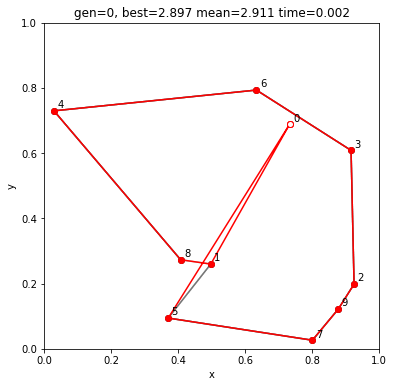

[0 5 7 9 2 3 6 4 8 1 0]


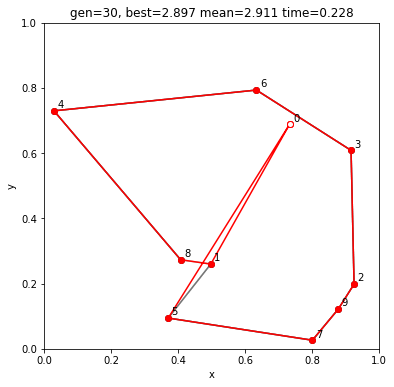

[0 5 7 9 2 3 6 4 8 1 0]


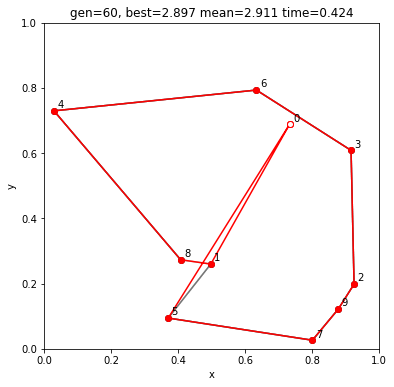

[0 5 7 9 2 3 6 4 8 1 0]


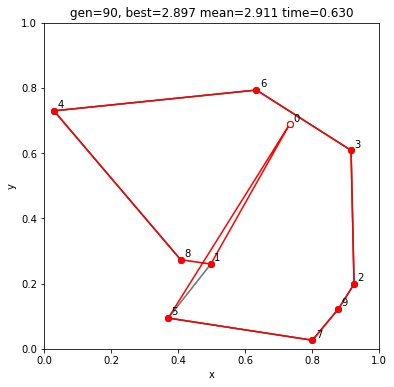

[0 5 7 9 2 3 6 4 8 1 0]


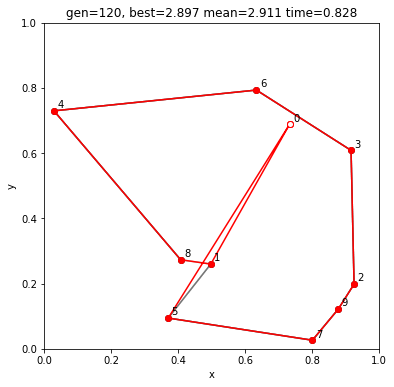

[0 5 7 9 2 3 6 4 8 1 0]


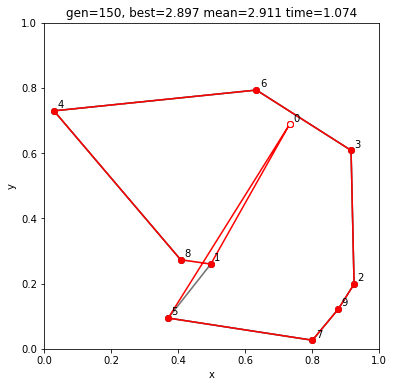

[0 5 7 9 2 3 6 4 8 1 0]


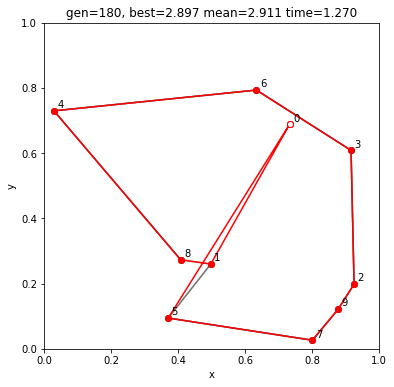

[0 5 7 9 2 3 6 4 8 1 0]


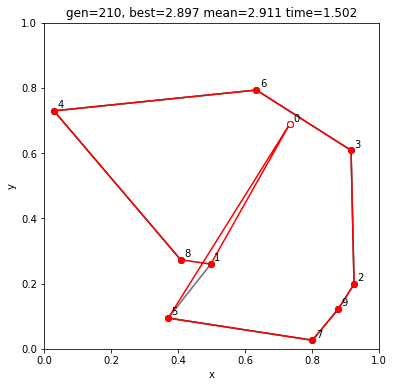

[0 5 7 9 2 3 6 4 8 1 0]


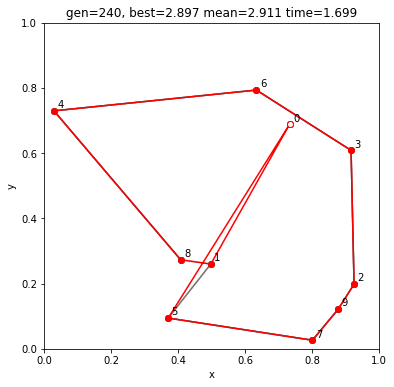

[0 5 7 9 2 3 6 4 8 1 0]


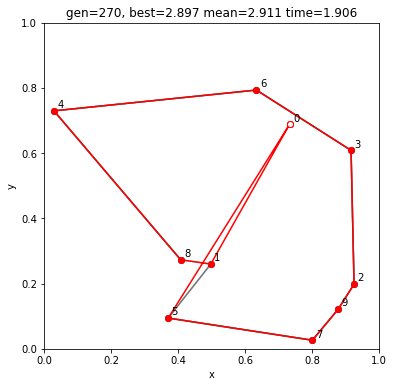

[0 5 7 9 2 3 6 4 8 1 0]


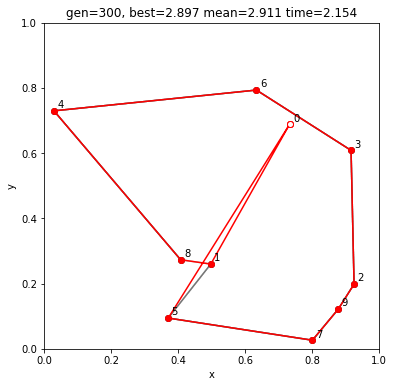

[0 5 7 9 2 3 6 4 8 1 0]


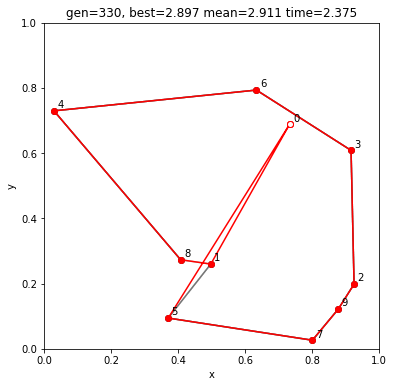

[0 5 7 9 2 3 6 4 8 1 0]


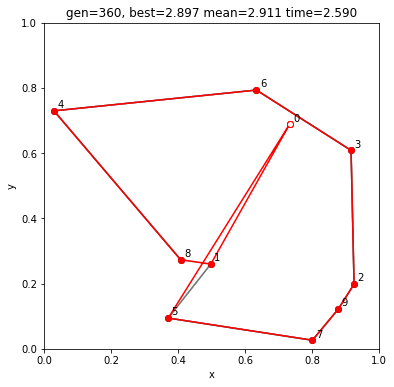

[0 5 7 9 2 3 6 4 8 1 0]


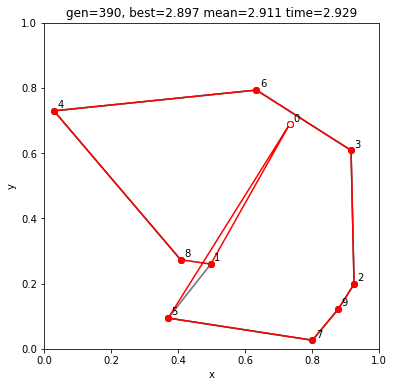

[0 5 7 9 2 3 6 4 8 1 0]


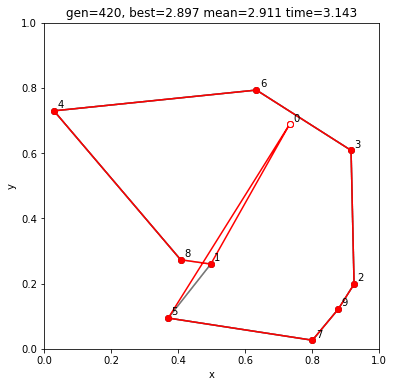

[0 5 7 9 2 3 6 4 8 1 0]


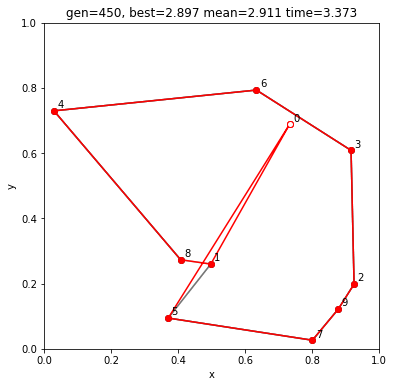

[0 5 7 9 2 3 6 4 8 1 0]


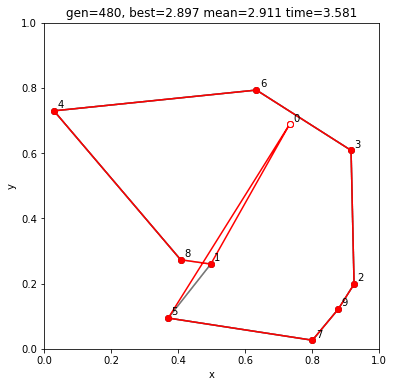

[0 5 7 9 2 3 6 4 8 1 0]


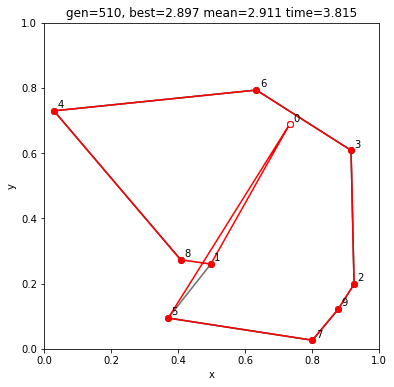

[0 5 7 9 2 3 6 4 8 1 0]


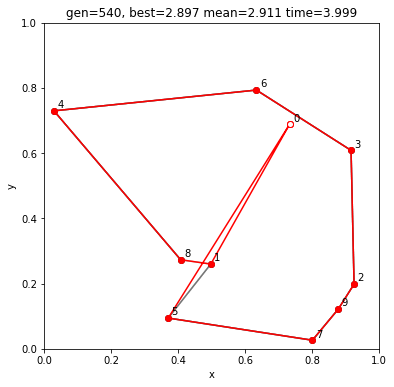

[0 5 7 9 2 3 6 4 8 1 0]


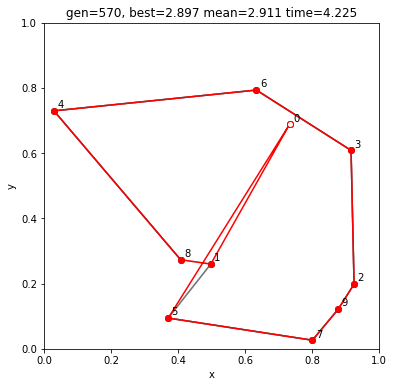

[0 5 7 9 2 3 6 4 8 1 0]


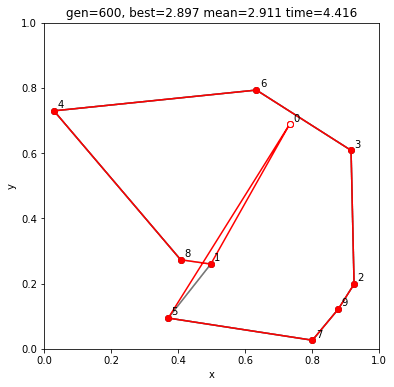

[0 5 7 9 2 3 6 4 8 1 0]


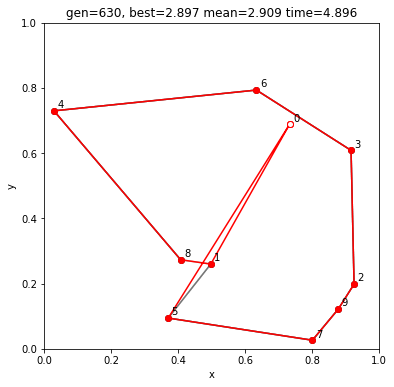

[0 5 7 9 2 3 6 4 8 1 0]


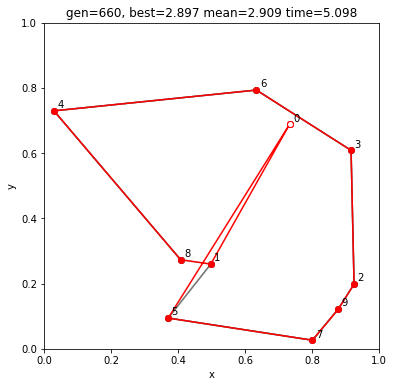

[0 5 7 9 2 3 6 4 8 1 0]


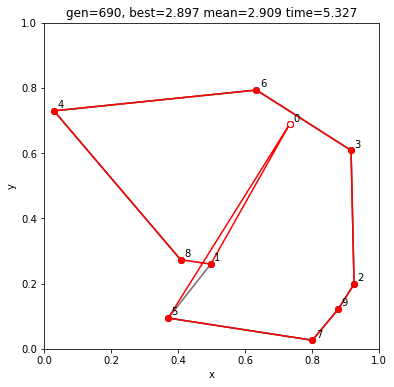

[0 5 7 9 2 3 6 4 8 1 0]


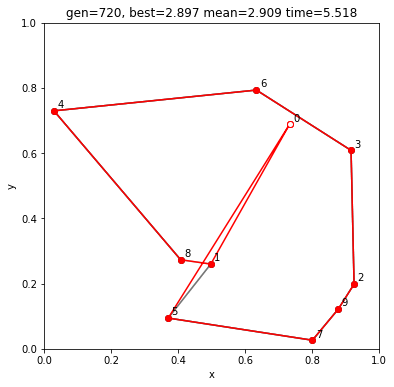

[0 5 7 9 2 3 6 4 8 1 0]


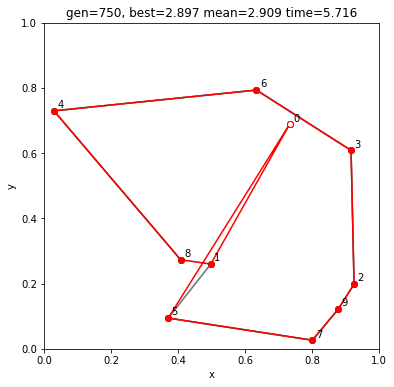

[0 5 7 9 2 3 6 4 8 1 0]


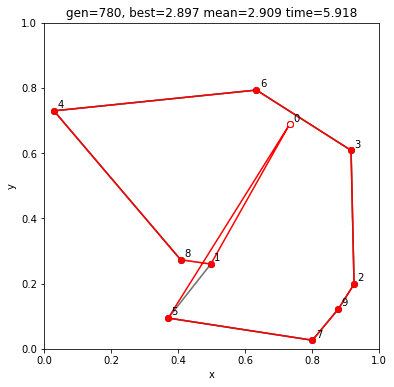

[0 5 7 9 2 3 6 4 8 1 0]


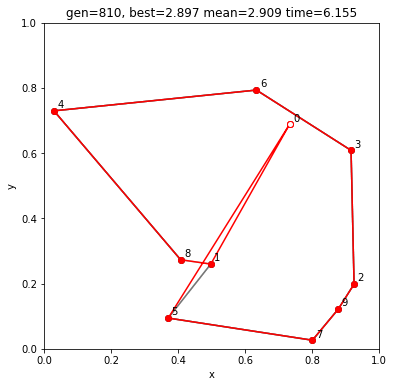

[0 5 7 9 2 3 6 4 8 1 0]


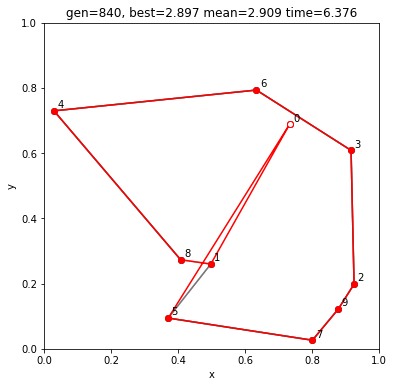

[0 5 7 9 2 3 6 4 8 1 0]


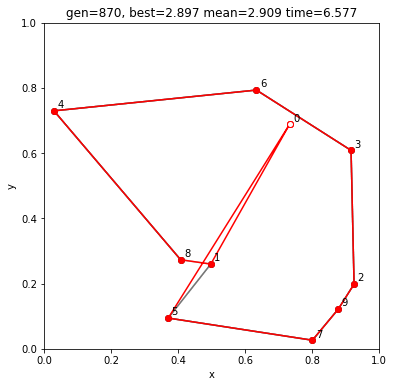

In [500]:
NO_GEN = 900
START_TIME = time.time()

for i in range(NO_GEN):
    population, costs, info = evolution(population, costs, mutation_rate=0.6, gen=i, start_time=START_TIME)
    
    if i % 30 == 0:
        tsp_show_pool(population, **info)
    
